# Задание 2. Свертки и базовые слои
Это задание будет являться духовным наследником первого.
Вы уже научились делать шаги градиентного спуска и вспомнили, как устроен базовый линейный слой.
На этой неделе мы построим прототип базового фреймворка до конца (собственно, многое вы сможете скопировать, если захотите).
Хоть вы уже и знаете о torch.nn, для выполнения задания его использовать нельзя.
Однако все элементы, которые вы будете реализовывать, достаточно просты.

In [1]:
!pip install wandb

In [ ]:
import random
import unittest

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image as PILImage
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import wandb

## Задание 1

### Задача 1. (2 балла)
Реализуйте слой BatchNorm (nn.BatchNorm).

BatchNorm нормализует данные по батчу:

$$\hat{x} = \frac{x - \mu_B}{\sqrt{\sigma_B^2 + \epsilon}}$$

$$y = \gamma \hat{x} + \beta$$

где:
- $\mu_B$ - среднее по батчу
- $\sigma_B^2$ - дисперсия по батчу
- $\gamma$ - обучаемый параметр масштаба
- $\beta$ - обучаемый параметр сдвига
- $\epsilon$ - малое число для численной устойчивости

В режиме eval используются скользящие средние:
- $\mu_{running} = (1 - momentum) \cdot \mu_{running} + momentum \cdot \mu_B$
- $\sigma^2_{running} = (1 - momentum) \cdot \sigma^2_{running} + momentum \cdot \sigma_B^2$

In [3]:
class BatchNorm:
    def __init__(self, num_features, eps=1e-5, momentum=0.1):
        """
        Args:
            num_features: количество каналов C
            eps: малое число для численной устойчивости
            momentum: коэффициент EMA для running_mean / running_var
        """
        self.num_features = num_features
        self.eps = eps
        self.momentum = momentum

        # Параметры (обучаемые)
        self.gamma = torch.ones(num_features, requires_grad=True)
        self.beta = torch.zeros(num_features, requires_grad=True)

        # Градиенты параметров
        self.gamma_grad = torch.zeros_like(self.gamma)
        self.beta_grad = torch.zeros_like(self.beta)

        # Скользящие статистики
        self.running_mean = torch.zeros(num_features)
        self.running_var = torch.ones(num_features)

        self.training = True

        # Промежуточные значения для backward
        self.cache = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        """
        Args:
            x: тензор NCHW или NC
        """
        if self.training:
            dims = list(range(len(x.shape)))
            dims.remove(1)

            batch_mean = x.mean(dim=dims, keepdim=True)
            batch_var = x.var(dim=dims, keepdim=True, unbiased=False)

            # сохраняем значения для backward
            x_centered = x - batch_mean
            std_inv = torch.rsqrt(batch_var + self.eps)  # 1/sqrt(var+eps)

            self.cache = (x_centered, std_inv, x.shape)

            # update running stats (NO grad!)
            self.running_mean = (
                (1 - self.momentum) * self.running_mean
                + self.momentum * batch_mean.squeeze().detach()
            )
            self.running_var = (
                (1 - self.momentum) * self.running_var
                + self.momentum * batch_var.squeeze().detach()
            )
        else:
            # использование running stats
            shape = (1, -1, *([1] * (len(x.shape) - 2)))
            batch_mean = self.running_mean.view(*shape)
            batch_var = self.running_var.view(*shape)
            x_centered = x - batch_mean
            std_inv = torch.rsqrt(batch_var + self.eps)

            # В eval режиме backward не нужен
            self.cache = None

        x_norm = x_centered * std_inv

        # affine
        shape = (1, -1, *([1] * (len(x.shape) - 2)))
        out = self.gamma.view(*shape) * x_norm + self.beta.view(*shape)
        return out

    def backward(self, grad_output):
        """
        Args:
          grad_output: dL/dY

        Returns:
          dL/dX
        """
        if self.cache is None:
            raise RuntimeError("Backward called in eval mode or before forward.")

        x_centered, std_inv, x_shape = self.cache
        N = x_shape[0]

        dims = list(range(len(x_shape)))
        dims.remove(1)

        # dγ = sum(dL/dY * x_norm)
        x_norm = x_centered * std_inv
        self.gamma_grad += (grad_output * x_norm).sum(dim=dims)

        # dβ = sum(dL/dY)
        self.beta_grad += grad_output.sum(dim=dims)

        # dX (сложная формула BN)
        dx_norm = grad_output * self.gamma.view(1, -1, *([1] * (len(x_shape) - 2)))

        dvar = (dx_norm * x_centered * -0.5 * std_inv**3).sum(dim=dims, keepdim=True)
        dmean = (
            (dx_norm * -std_inv).sum(dim=dims, keepdim=True)
            + dvar * (x_centered * -2 / N).sum(dim=dims, keepdim=True)
        )

        dx = (
            dx_norm * std_inv
            + dvar * 2 * x_centered / N
            + dmean / N
        )

        return dx

    def zero_grad(self):
        """Обнулить градиенты параметров."""
        self.gamma_grad.zero_()
        self.beta_grad.zero_()

    def parameters(self):
        return [
            (self.gamma, self.gamma_grad),
            (self.beta, self.beta_grad)
        ]

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

### Задача 2. (2 балла)
Реализуйте слой Linear (nn.Linear).

Линейное преобразование:

$$y = xW^T + b$$

где:
- $x$ - входной тензор формы $(N, in\_features)$
- $W$ - матрица весов формы $(out\_features, in\_features)$
- $b$ - вектор смещений формы $(out\_features,)$
- $y$ - выходной тензор формы $(N, out\_features)$

In [4]:
class Linear:
    def __init__(self, in_features, out_features, bias=True):
        """
        Args:
            in_features: размер входного вектора
            out_features: размер выхода
            bias: включать ли смещение
        """
        self.in_features = in_features
        self.out_features = out_features
        self.use_bias = bias

        # Параметры (обучаемые)
        limit = (1.0 / in_features) ** 0.5
        self.W = torch.empty(out_features, in_features).uniform_(-limit, limit)
        self.W.requires_grad = True

        if bias:
            self.b = torch.empty(out_features).uniform_(-limit, limit)
            self.b.requires_grad = True
        else:
            self.b = None

        # Градиенты
        self.W_grad = torch.zeros_like(self.W)
        self.b_grad = torch.zeros_like(self.b) if bias else None

        # Кэш для backward
        self.x_cache = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        """
        Args:
            x: (N, in_features)
        Returns:
            (N, out_features)
        """
        self.x_cache = x
        out = x @ self.W.T  # (N F_in) @ (F_out F_in)^T -> (N F_out)

        if self.use_bias:
            out += self.b.view(1, -1)  # добавляем смещение

        return out

    def backward(self, grad_output):
        """
        Args:
            grad_output: dL/dY, shape (N, out_features)
        Returns:
            dL/dX: (N, in_features)
        """
        x = self.x_cache

        # dL/dW
        # grad_output: (N, F_out)
        # x: (N, F_in)
        self.W_grad += grad_output.T @ x  # (F_out N) @ (N F_in)

        # dL/db
        if self.use_bias:
            self.b_grad += grad_output.sum(dim=0)

        # dL/dX
        grad_input = grad_output @ self.W  # (N F_out) @ (F_out F_in)

        return grad_input

    def zero_grad(self):
        self.W_grad.zero_()
        if self.use_bias:
            self.b_grad.zero_()

    def parameters(self):
        if self.use_bias:
            return [
                (self.W, self.W_grad),
                (self.b, self.b_grad)
            ]
        else:
            return [
                (self.W, self.W_grad)
            ]

### Задача 3. (2 балла)
Реализуйте слой Dropout(nn.Dropout)

В режиме обучения:
$$y = \frac{x \odot m}{1 - p}$$

где:
- $m \sim \text{Bernoulli}(1-p)$ - маска
- $p$ - вероятность дропаута
- $\odot$ - поэлементное умножение

В режиме eval: $y = x$ (без изменений)

In [5]:
class Dropout:
    def __init__(self, p=0.5):
        """
        Args:
            p: вероятность зануления нейронов
        """
        assert 0 <= p < 1, "p должно быть в диапазоне [0, 1)"
        self.p = p
        self.training = True

        # В Dropout нет learnable parameters
        self._parameters = []
        self._grads = []

        self.mask = None

    def __call__(self, x):
        return self.forward(x)

    def forward(self, x):
        if self.training:
            # mask ~ Bernoulli(1-p)
            self.mask = (torch.rand_like(x) > self.p).float()
            out = x * self.mask
            out = out / (1 - self.p)  # inverted dropout
            return out
        else:
            # В eval режимe dropout отключён
            self.mask = None
            return x

    def backward(self, grad_output):
        """
        dL/dx = dL/dy * mask / (1-p)
        """
        if self.training:
            return grad_output * self.mask / (1 - self.p)
        else:
            # Нет маски - слой пропускает градиент как есть
            return grad_output

    def train(self):
        self.training = True

    def eval(self):
        self.training = False

    def parameters(self):
        return []

    def grads(self):
        return []

### Задача 4. {*} (2 балла, 1 за каждый следующий за слой)
Реализуйте одно или более из:
  - слой ReLU(nn.ReLU)
  - слой Sigmoid(nn.Sigmoid)
  - слой Softmax(nn.Softmax)

**ReLU:**
$$\text{ReLU}(x) = \max(0, x)$$

In [6]:
class ReLU:
    def __init__(self):
        self.mask = None

    def forward(self, x):
        self.mask = x > 0
        return x * self.mask

    def backward(self, grad_output):
        return grad_output * self.mask

    def __call__(self, x):
        return self.forward(x)

**Sigmoid:**
$$\sigma(x) = \frac{1}{1 + e^{-x}}$$

In [7]:
class Sigmoid:
    def __init__(self):
        self.out = None

    def forward(self, x):
        self.out = 1.0 / (1.0 + np.exp(-x))
        return self.out

    def backward(self, grad_output):
        # derivative: sigmoid(x) * (1 - sigmoid(x))
        return grad_output * self.out * (1.0 - self.out)

    def __call__(self, x):
        return self.forward(x)

**Softmax:**
$$\text{Softmax}(x_i) = \frac{e^{x_i}}{\sum_{j=1}^{n} e^{x_j}}$$

In [8]:
class Softmax:
    def __init__(self, axis=-1):
        self.axis = axis
        self.out = None

    def forward(self, x):
        # стабильная версия softmax
        shifted = x - np.max(x, axis=self.axis, keepdims=True)
        exp = np.exp(shifted)
        self.out = exp / np.sum(exp, axis=self.axis, keepdims=True)
        return self.out

    def backward(self, grad_output):
        # Полная формула Якобиана softmax
        batch = self.out.reshape(-1, self.out.shape[-1])
        grad_input = np.zeros_like(batch)

        for i in range(batch.shape[0]):
            s = batch[i]
            J = np.diag(s) - np.outer(s, s)
            grad_input[i] = grad_output.reshape(batch.shape)[i] @ J

        return grad_input.reshape(self.out.shape)

    def __call__(self, x):
        return self.forward(x)

In [9]:
class TestActivations(unittest.TestCase):
    def test_relu_forward(self):
        """Проверяет, что ReLU корректно обнуляет отрицательные значения."""
        relu = ReLU()
        x = np.array([-1, 0, 2])
        y = relu(x)
        np.testing.assert_array_equal(y, np.array([0, 0, 2]))

    def test_relu_backward(self):
        """Проверяет, что градиент ReLU передаётся только там, где x > 0."""
        relu = ReLU()
        x = np.array([-1.0, 2.0])
        relu.forward(x)
        grad = np.array([1.0, 1.0])
        out = relu.backward(grad)
        np.testing.assert_array_equal(out, np.array([0.0, 1.0]))

    def test_sigmoid_forward(self):
        """Проверяет корректность вычисления Sigmoid(0) = 0.5."""
        sigmoid = Sigmoid()
        x = np.array([0.0])
        y = sigmoid(x)
        self.assertAlmostEqual(y[0], 0.5, places=6)

    def test_sigmoid_backward(self):
        """Проверяет формулу производной sigmoid'(0) = 0.25."""
        sigmoid = Sigmoid()
        x = np.array([0.0])
        sigmoid.forward(x)
        grad = np.array([1.0])
        out = sigmoid.backward(grad)
        self.assertAlmostEqual(out[0], 0.25, places=6)

    def test_softmax_forward(self):
        """Проверяет, что Softmax выдаёт нормированное распределение."""
        sm = Softmax()
        x = np.array([1.0, 2.0, 3.0])
        y = sm(x)
        expected = np.exp(x) / np.sum(np.exp(x))
        np.testing.assert_allclose(y, expected, rtol=1e-6)

    def test_softmax_backward(self):
        """Проверяет градиент Softmax с помощью численного расчёта (finite differences)."""
        sm = Softmax()
        x = np.array([1.0, 2.0, 3.0])
        sm.forward(x)
        grad = np.array([1.0, 0.0, -1.0])
        out = sm.backward(grad)

        # Численная проверка
        eps = 1e-5
        num_grad = np.zeros_like(x)
        for i in range(len(x)):
            x1 = x.copy()
            x1[i] += eps
            x2 = x.copy()
            x2[i] -= eps
            y1 = sm.forward(x1)
            y2 = sm.forward(x2)
            num_grad[i] = (np.sum(y1 * grad) - np.sum(y2 * grad)) / (2 * eps)

        np.testing.assert_allclose(out, num_grad, rtol=1e-4, atol=1e-4)


unittest.main(argv=[''], verbosity=2, exit=False)

test_relu_backward (__main__.TestActivations.test_relu_backward)
Проверяет, что градиент ReLU передаётся только там, где x > 0. ... ok
test_relu_forward (__main__.TestActivations.test_relu_forward)
Проверяет, что ReLU корректно обнуляет отрицательные значения. ... ok
test_sigmoid_backward (__main__.TestActivations.test_sigmoid_backward)
Проверяет формулу производной sigmoid'(0) = 0.25. ... ok
test_sigmoid_forward (__main__.TestActivations.test_sigmoid_forward)
Проверяет корректность вычисления Sigmoid(0) = 0.5. ... ok
test_softmax_backward (__main__.TestActivations.test_softmax_backward)
Проверяет градиент Softmax с помощью численного расчёта (finite differences). ... ok
test_softmax_forward (__main__.TestActivations.test_softmax_forward)
Проверяет, что Softmax выдаёт нормированное распределение. ... ok

----------------------------------------------------------------------
Ran 6 tests in 0.024s

OK


## Задание 2. {*} 3 балла
Реализуйте медианный фильтр.
Для текущего пикселя, пиксели, которые «попадают» в матрицу,
сортируются, и выбирается медианное значение из отсортированного массива.
Это значение и является выходным для текущего пикселя.
Используйте только чистый torch. Покажите результат на примере для размера ядра 3, 5, 10

Шум Перлина — это математический алгоритм, который генерирует псевдослучайные текстуры с плавными переходами, а не резкими пиксельными изменениями. Он создает узор, похожий на облака или водную поверхность, путем интерполяции (сглаживания) значений между псевдослучайными векторами, заданными в узлах сетки

In [10]:
def generate_perlin_noise(size, scale=10, seed=None):
    """Генерирует шум Перлина.

    Args:
        size: размер изображения (height, width)
        scale: масштаб шума
        seed: seed для воспроизводимости
    """
    if seed is not None:
        torch.manual_seed(seed)

    h, w = size
    # Создаем сетку координат
    x = torch.linspace(0, scale, w)
    y = torch.linspace(0, scale, h)
    X, Y = torch.meshgrid(x, y, indexing='xy')

    # Генерируем случайные градиенты
    angles = torch.rand(2, 2) * 2 * np.pi
    grad_x = torch.cos(angles)
    grad_y = torch.sin(angles)

    # Интерполяция
    noise = torch.sin(X * 0.1) * torch.cos(Y * 0.1) + torch.randn(h, w) * 0.3
    noise = (noise - noise.min()) / (noise.max() - noise.min())

    return noise

In [11]:
def median_filter(image, kernel_size):
    """Медианный фильтр.

    Args:
        image: тензор формы (H, W) или (C, H, W)
        kernel_size: размер ядра (нечетное число)
    Returns:
        отфильтрованное изображение той же формы
    """
    if len(image.shape) == 2:
        image = image.unsqueeze(0)
        single_channel = True
    else:
        single_channel = False

    C, H, W = image.shape
    pad = kernel_size // 2
    output = torch.zeros_like(image)

    padded = torch.nn.functional.pad(image, (pad, pad, pad, pad), mode='reflect')

    for c in range(C):
        for i in range(H):
            for j in range(W):
                # Извлекаем окно
                window = padded[c, i:i+kernel_size, j:j+kernel_size]
                # Находим медиану
                output[c, i, j] = window.median()

    if single_channel:
        output = output.squeeze(0)

    return output

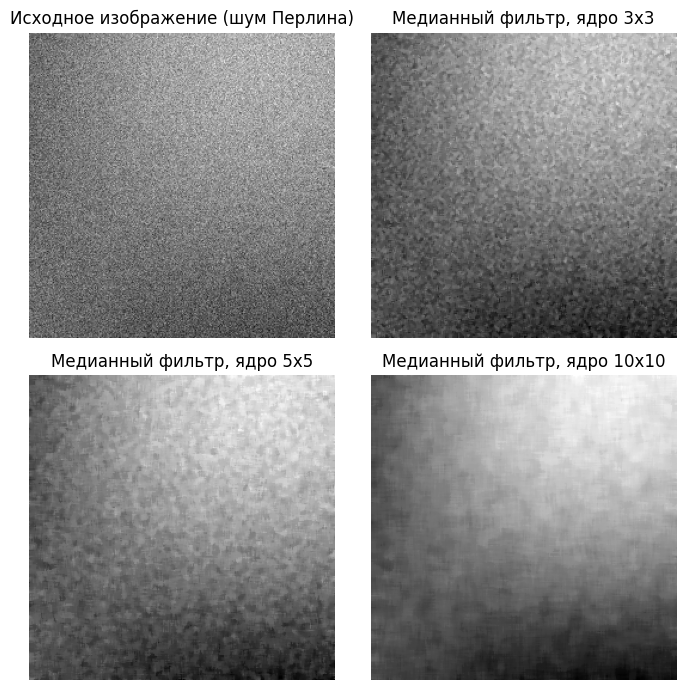

In [12]:
img_size = (256, 256)
noise_img = generate_perlin_noise(img_size, scale=20, seed=42)

kernels = [3, 5, 10]
filtered_images = [median_filter(noise_img, k) for k in kernels]

fig, axes = plt.subplots(2, 2, figsize=(7, 7))
axes[0, 0].imshow(noise_img, cmap='gray')
axes[0, 0].set_title('Исходное изображение (шум Перлина)')
axes[0, 0].axis('off')

for idx, (k, filtered) in enumerate(zip(kernels, filtered_images)):
    row = (idx + 1) // 2
    col = (idx + 1) % 2
    axes[row, col].imshow(filtered, cmap='gray')
    axes[row, col].set_title(f'Медианный фильтр, ядро {k}x{k}')
    axes[row, col].axis('off')

plt.tight_layout()
plt.show()

Медианный фильтр эффективно сглаживает шум: при увеличении размера ядра результат становится более размытым. Таким образом, увеличение размера ядра повышает степень фильтрации, но снижает резкость изображения

## Задание 3. 6 баллов
Реализуйте следующие классы (указана сигнатура __init__):
- BaseTransform(p: float) [*базовый класс для всех трансформаций*]
- RandomCrop(p: float, **kwargs)
- RandomRotate(p: float, **kwargs)
- RandomZoom(p: float, **kwargs) {*}
- ToTensor()
- Compose(list[BaseTransform])

Последний класс должен принимать на вход список инстансов трех других.
При вызове метода __call__ он должен последовательно вызывать трансформации из списка.
При вызове каждого из них с вероятностью p должно
применяться изменение изображения, с вероятностью 1-p должно возвращаться исходное
изображение. Класс входного изображения у всех классов - PIL.Image, выходного тоже.
Класс ToTensor должен принимать на вход PIL.Image, возвращать - torch.Tensor.

**torch.nn использовать нельзя!**

{*} (1 балл) Протестируйте ваши классы на воспроизводимость, результат, граничные случаи.

In [13]:
class BaseTransform:
    """Базовый класс для всех трансформаций.

    С вероятностью p применяет трансформацию, иначе возвращает исходное изображение.
    """

    def __init__(self, p: float):
        """
        Args:
            p: вероятность применения трансформации (0 <= p <= 1)
        """
        self.p = p

    def __call__(self, img: PILImage.Image) -> PILImage.Image:
        """Применяет трансформацию с вероятностью p."""
        if random.random() < self.p:
            return self.apply(img)
        return img

    def apply(self, img: PILImage.Image) -> PILImage.Image:
        """Применяет трансформацию. Должен быть переопределен в подклассах."""
        raise NotImplementedError

In [14]:
class RandomCrop(BaseTransform):
    """Случайный кроп изображения."""

    def __init__(self, p: float, size: tuple = None, **kwargs):
        """
        Args:
            p: вероятность применения
            size: размер кропа (height, width). Если None, берется 80% от исходного размера
        """
        super().__init__(p)
        self.size = size
        self.kwargs = kwargs

    def apply(self, img: PILImage.Image) -> PILImage.Image:
        width, height = img.size

        if self.size is None:
            crop_h = int(height * 0.8)
            crop_w = int(width * 0.8)
        else:
            crop_h, crop_w = self.size

        # Ограничиваем размер кропа размером изображения
        crop_h = min(crop_h, height)
        crop_w = min(crop_w, width)

        # Случайная позиция для кропа
        top = random.randint(0, height - crop_h)
        left = random.randint(0, width - crop_w)

        return img.crop((left, top, left + crop_w, top + crop_h))

In [15]:
class RandomRotate(BaseTransform):
    """Случайный поворот изображения."""

    def __init__(self, p: float, degrees: float = 15, **kwargs):
        """
        Args:
            p: вероятность применения
            degrees: максимальный угол поворота в градусах
        """
        super().__init__(p)
        self.degrees = degrees
        self.kwargs = kwargs

    def apply(self, img: PILImage.Image) -> PILImage.Image:
        angle = random.uniform(-self.degrees, self.degrees)
        return img.rotate(angle, expand=False, fillcolor='white')

In [16]:
class RandomZoom(BaseTransform):
    """Случайное масштабирование изображения."""

    def __init__(self, p: float, zoom_range: tuple = (0.8, 1.2), **kwargs):
        """
        Args:
            p: вероятность применения
            zoom_range: диапазон масштабирования (min_zoom, max_zoom)
        """
        super().__init__(p)
        self.zoom_range = zoom_range
        self.kwargs = kwargs

    def apply(self, img: PILImage.Image) -> PILImage.Image:
        width, height = img.size
        zoom_factor = random.uniform(self.zoom_range[0], self.zoom_range[1])

        new_width = int(width * zoom_factor)
        new_height = int(height * zoom_factor)

        # Масштабируем
        img_zoomed = img.resize((new_width, new_height), PILImage.BILINEAR)

        # Если увеличили - кропаем до исходного размера
        if zoom_factor > 1.0:
            left = (new_width - width) // 2
            top = (new_height - height) // 2
            return img_zoomed.crop((left, top, left + width, top + height))
        # Если уменьшили - добавляем padding
        else:
            result = PILImage.new(img.mode, (width, height), 'white')
            paste_x = (width - new_width) // 2
            paste_y = (height - new_height) // 2
            result.paste(img_zoomed, (paste_x, paste_y))
            return result

In [17]:
class ToTensor:
    """Преобразует PIL.Image в torch.Tensor."""

    def __call__(self, img: PILImage.Image) -> torch.Tensor:
        """
        Args:
            img: PIL.Image
        Returns:
            torch.Tensor формы (C, H, W) с значениями в [0, 1]
        """
        # Конвертируем в numpy array
        img_array = np.array(img, dtype=np.float32) / 255.0

        # Если grayscale, добавляем канал
        if len(img_array.shape) == 2:
            img_array = img_array[np.newaxis, :, :]
        else:
            # Если RGB, переставляем (H, W, C) -> (C, H, W)
            img_array = img_array.transpose(2, 0, 1)

        return torch.from_numpy(img_array)

In [18]:
class Compose:
    """Композиция трансформаций."""

    def __init__(self, transforms: list):
        """
        Args:
            transforms: список трансформаций (экземпляры BaseTransform или ToTensor)
        """
        self.transforms = transforms

    def __call__(self, img: PILImage.Image):
        """Применяет трансформации последовательно."""
        for transform in self.transforms:
            img = transform(img)
        return img

In [19]:
class TestTransforms(unittest.TestCase):
    """Тесты для трансформаций."""

    def test_random_crop(self):
        """Тест RandomCrop."""
        random.seed(42)
        crop = RandomCrop(p=1.0, size=(50, 50))
        cropped = crop(noise_img)
        self.assertEqual(cropped.size, (50, 50))

        # Граничный случай: размер кропа больше изображения
        crop_large = RandomCrop(p=1.0, size=(200, 200))
        cropped_large = crop_large(noise_img)
        self.assertLessEqual(cropped_large.size[0], noise_img.size[0])
        self.assertLessEqual(cropped_large.size[1], noise_img.size[1])

    def test_random_rotate(self):
        """Тест RandomRotate."""
        random.seed(42)
        rotate = RandomRotate(p=1.0, degrees=10)
        rotated = rotate(noise_img)
        self.assertEqual(rotated.size, noise_img.size)

    def test_random_zoom(self):
        """Тест RandomZoom."""
        random.seed(42)
        zoom = RandomZoom(p=1.0, zoom_range=(0.9, 1.1))
        zoomed = zoom(noise_img)
        self.assertEqual(zoomed.size, noise_img.size)

    def test_to_tensor(self):
        """Тест ToTensor."""
        to_tensor = ToTensor()
        tensor = to_tensor(noise_img)
        self.assertIsInstance(tensor, torch.Tensor)
        self.assertEqual(len(tensor.shape), 3)  # (C, H, W)
        self.assertTrue((tensor >= 0).all() and (tensor <= 1).all())

    def test_compose(self):
        """Тест Compose."""
        random.seed(42)
        compose = Compose([
            RandomCrop(p=1.0, size=(80, 80)),
            RandomRotate(p=1.0, degrees=5),
            ToTensor()
        ])
        result = compose(noise_img)
        self.assertIsInstance(result, torch.Tensor)

    def test_probability(self):
        """Тест вероятности применения трансформации."""
        random.seed(42)
        # При p=0 трансформация не должна применяться
        crop = RandomCrop(p=0.0, size=(50, 50))
        result = crop(noise_img)
        self.assertEqual(result.size, noise_img.size)

        # При p=1.0 должна применяться всегда
        random.seed(42)
        crop = RandomCrop(p=1.0, size=(50, 50))
        result = crop(noise_img)
        self.assertEqual(result.size, (50, 50))

    def test_reproducibility(self):
        """Тест воспроизводимости с одинаковым seed."""
        # Создаем два одинаковых изображения
        img1 = PILImage.new('L', (100, 100), color=128)
        img2 = PILImage.new('L', (100, 100), color=128)

        # Применяем с одинаковым seed
        random.seed(42)
        crop1 = RandomCrop(p=1.0, size=(80, 80))
        result1 = crop1(img1)

        random.seed(42)
        crop2 = RandomCrop(p=1.0, size=(80, 80))
        result2 = crop2(img2)

        # Результаты должны быть одинаковыми
        self.assertEqual(result1.size, result2.size)

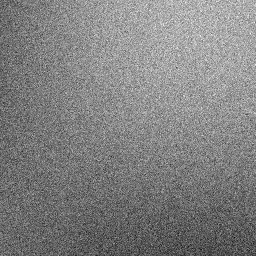

In [20]:
noise_img = transforms.functional.to_pil_image(noise_img, mode=None)
noise_img

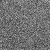

In [21]:
crop = RandomCrop(p=1.0, size=(50, 50))
cropped = crop(noise_img)
cropped

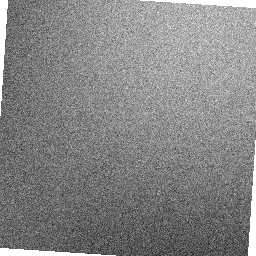

In [22]:
rotate = RandomRotate(p=1.0, degrees=10)
rotated = rotate(noise_img)
rotated

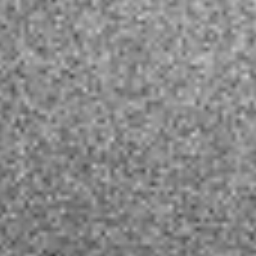

In [25]:
zoom = RandomZoom(p=1.0, zoom_range=(4.5, 4.5))
zoomed = zoom(noise_img)
zoomed

In [26]:
suite = unittest.TestLoader().loadTestsFromTestCase(TestTransforms)
runner = unittest.TextTestRunner(verbosity=2)
result = runner.run(suite)

test_compose (__main__.TestTransforms.test_compose)
Тест Compose. ... ok
test_probability (__main__.TestTransforms.test_probability)
Тест вероятности применения трансформации. ... ok
test_random_crop (__main__.TestTransforms.test_random_crop)
Тест RandomCrop. ... ok
test_random_rotate (__main__.TestTransforms.test_random_rotate)
Тест RandomRotate. ... ok
test_random_zoom (__main__.TestTransforms.test_random_zoom)
Тест RandomZoom. ... ok
test_reproducibility (__main__.TestTransforms.test_reproducibility)
Тест воспроизводимости с одинаковым seed. ... ok
test_to_tensor (__main__.TestTransforms.test_to_tensor)
Тест ToTensor. ... ok

----------------------------------------------------------------------
Ran 7 tests in 0.028s

OK


## Задание 4. 3 балла
Примените трансформации из задания 3 в качестве трансформаций датасета из практики 2.2.
**В этом задании можно пользоваться torch.nn, за исключением трансформаций.**
Покажите, как меняются лосс и метрики на трейне и на тесте в зависимости от количества и вероятностей трансформаций.
Проведите обучение на большом количестве эпох.
Опишите, что вы наблюдаете для каждого случая и какая есть разница,
если применить трансформации.
Предоставьте графики в matplotlib или tensorboard (+1 балл) в
ноутбуке (в случае с tensorboard можно в отдельном окне) с наглядными примерами

In [27]:
BATCH_SIZE = 64
LEARNING_RATE = 0.001
NUM_EPOCHS = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [36]:
class FixTensorShape:
    def __init__(self, target_size=(28, 28)):
        self.target_size = target_size

    def __call__(self, tensor):
        # tensor shape: (C, H, W)
        c, h, w = tensor.shape
        th, tw = self.target_size

        # Если меньше — паддинг (центрированный)
        pad_h = max(0, th - h)
        pad_w = max(0, tw - w)

        if pad_h > 0 or pad_w > 0:
            pad_top = pad_h // 2
            pad_bottom = pad_h - pad_top
            pad_left = pad_w // 2
            pad_right = pad_w - pad_left
            tensor = F.pad(tensor, (pad_left, pad_right, pad_top, pad_bottom))

        # Если больше — центрированная обрезка
        if tensor.shape[1] > th:
            extra = tensor.shape[1] - th
            start = extra // 2
            tensor = tensor[:, start:start+th, :]

        if tensor.shape[2] > tw:
            extra = tensor.shape[2] - tw
            start = extra // 2
            tensor = tensor[:, :, start:start+tw]

        return tensor

In [46]:
def create_dataset(transforms_list, train=True):
    """Создает FashionMNIST датасет с заданными трансформациями."""
    # Сначала применяем наши трансформации, затем ToTensor
    if transforms_list:
        transforms = Compose(transforms_list + [ToTensor(), FixTensorShape((28, 28))])
    else:
        transforms = ToTensor()

    dataset = datasets.FashionMNIST(
        root='data',
        train=train,
        download=True,
        transform=transforms
    )
    return dataset

In [29]:
train_data_no_aug = datasets.FashionMNIST(
    root='data',
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.6MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 201kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.74MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 10.5MB/s]


In [47]:
train_data_aug1 = create_dataset([
    RandomCrop(p=0.5, size=(24, 24)),
    RandomRotate(p=0.5, degrees=10)
], train=True)

train_data_aug2 = create_dataset([
    RandomCrop(p=0.8, size=(24, 24)),
    RandomRotate(p=0.8, degrees=15),
    RandomZoom(p=0.5, zoom_range=(0.9, 1.1))
], train=True)

print(f"Размер train без аугментации: {len(train_data_no_aug)}")
print(f"Размер train с аугментацией 1: {len(train_data_aug1)}")
print(f"Размер test: {len(test_data)}")

Размер train без аугментации: 60000
Размер train с аугментацией 1: 60000
Размер test: 10000


In [30]:
class SimpleCNN(nn.Module):
    """Простая CNN для FashionMNIST."""

    def __init__(self, num_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [32]:
def train_model(model, train_loader, test_loader, num_epochs, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total
        train_losses.append(train_loss)
        train_accs.append(train_acc)

        # Тестирование
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100 * test_correct / test_total
        test_losses.append(test_loss)
        test_accs.append(test_acc)

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs
    }

In [33]:
results = {}

print("=" * 50)
print("Обучение БЕЗ аугментации")
print("=" * 50)
train_loader_no_aug = DataLoader(train_data_no_aug, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

model_no_aug = SimpleCNN().to(DEVICE)
results['no_aug'] = train_model(model_no_aug, train_loader_no_aug, test_loader, NUM_EPOCHS, DEVICE)

Обучение БЕЗ аугментации


Epoch 1/10: 100%|██████████| 938/938 [00:08<00:00, 113.47it/s]


Epoch 1: Train Loss: 0.6000, Train Acc: 78.11%, Test Loss: 0.3752, Test Acc: 86.28%


Epoch 2/10: 100%|██████████| 938/938 [00:06<00:00, 136.28it/s]


Epoch 2: Train Loss: 0.3951, Train Acc: 85.88%, Test Loss: 0.3324, Test Acc: 87.86%


Epoch 3/10: 100%|██████████| 938/938 [00:07<00:00, 131.37it/s]


Epoch 3: Train Loss: 0.3426, Train Acc: 87.64%, Test Loss: 0.2922, Test Acc: 89.42%


Epoch 4/10: 100%|██████████| 938/938 [00:07<00:00, 129.70it/s]


Epoch 4: Train Loss: 0.3077, Train Acc: 88.85%, Test Loss: 0.2724, Test Acc: 90.05%


Epoch 5/10: 100%|██████████| 938/938 [00:06<00:00, 142.19it/s]


Epoch 5: Train Loss: 0.2847, Train Acc: 89.78%, Test Loss: 0.2489, Test Acc: 90.82%


Epoch 6/10: 100%|██████████| 938/938 [00:07<00:00, 132.67it/s]


Epoch 6: Train Loss: 0.2621, Train Acc: 90.48%, Test Loss: 0.2748, Test Acc: 90.01%


Epoch 7/10: 100%|██████████| 938/938 [00:06<00:00, 140.60it/s]


Epoch 7: Train Loss: 0.2445, Train Acc: 91.00%, Test Loss: 0.2426, Test Acc: 91.19%


Epoch 8/10: 100%|██████████| 938/938 [00:06<00:00, 138.17it/s]


Epoch 8: Train Loss: 0.2322, Train Acc: 91.35%, Test Loss: 0.2460, Test Acc: 91.05%


Epoch 9/10: 100%|██████████| 938/938 [00:07<00:00, 132.22it/s]


Epoch 9: Train Loss: 0.2180, Train Acc: 91.99%, Test Loss: 0.2369, Test Acc: 91.60%


Epoch 10/10: 100%|██████████| 938/938 [00:06<00:00, 142.71it/s]


Epoch 10: Train Loss: 0.2079, Train Acc: 92.18%, Test Loss: 0.2272, Test Acc: 91.96%


In [48]:
print("\n" + "=" * 50)
print("Обучение С легкой аугментацией (p=0.5)")
print("=" * 50)
train_loader_aug1 = DataLoader(train_data_aug1, batch_size=BATCH_SIZE, shuffle=True)

model_aug1 = SimpleCNN().to(DEVICE)
results['aug1'] = train_model(model_aug1, train_loader_aug1, test_loader, NUM_EPOCHS, DEVICE)


Обучение С легкой аугментацией (p=0.5)


Epoch 1/10: 100%|██████████| 938/938 [00:10<00:00, 91.31it/s]


Epoch 1: Train Loss: 0.7544, Train Acc: 71.47%, Test Loss: 0.4703, Test Acc: 81.12%


Epoch 2/10: 100%|██████████| 938/938 [00:10<00:00, 92.15it/s]


Epoch 2: Train Loss: 0.5543, Train Acc: 79.11%, Test Loss: 0.3904, Test Acc: 85.62%


Epoch 3/10: 100%|██████████| 938/938 [00:12<00:00, 77.95it/s]


Epoch 3: Train Loss: 0.4947, Train Acc: 81.61%, Test Loss: 0.3386, Test Acc: 87.93%


Epoch 4/10: 100%|██████████| 938/938 [00:09<00:00, 94.49it/s]


Epoch 4: Train Loss: 0.4556, Train Acc: 83.27%, Test Loss: 0.3238, Test Acc: 88.12%


Epoch 5/10: 100%|██████████| 938/938 [00:09<00:00, 94.16it/s]


Epoch 5: Train Loss: 0.4295, Train Acc: 84.14%, Test Loss: 0.2967, Test Acc: 89.35%


Epoch 6/10: 100%|██████████| 938/938 [00:10<00:00, 93.16it/s]


Epoch 6: Train Loss: 0.4092, Train Acc: 84.91%, Test Loss: 0.2928, Test Acc: 89.61%


Epoch 7/10: 100%|██████████| 938/938 [00:10<00:00, 91.39it/s]


Epoch 7: Train Loss: 0.3929, Train Acc: 85.66%, Test Loss: 0.2726, Test Acc: 90.24%


Epoch 8/10: 100%|██████████| 938/938 [00:10<00:00, 89.37it/s]


Epoch 8: Train Loss: 0.3756, Train Acc: 86.24%, Test Loss: 0.2624, Test Acc: 90.46%


Epoch 9/10: 100%|██████████| 938/938 [00:10<00:00, 90.25it/s]


Epoch 9: Train Loss: 0.3650, Train Acc: 86.69%, Test Loss: 0.2719, Test Acc: 90.24%


Epoch 10/10: 100%|██████████| 938/938 [00:10<00:00, 91.12it/s]


Epoch 10: Train Loss: 0.3568, Train Acc: 87.09%, Test Loss: 0.2465, Test Acc: 90.94%


In [49]:
print("\n" + "=" * 50)
print("Обучение С сильной аугментацией (p=0.8)")
print("=" * 50)
train_loader_aug2 = DataLoader(train_data_aug2, batch_size=BATCH_SIZE, shuffle=True)

model_aug2 = SimpleCNN().to(DEVICE)
results['aug2'] = train_model(model_aug2, train_loader_aug2, test_loader, NUM_EPOCHS, DEVICE)


Обучение С сильной аугментацией (p=0.8)


Epoch 1/10: 100%|██████████| 938/938 [00:12<00:00, 76.00it/s]


Epoch 1: Train Loss: 0.8167, Train Acc: 69.22%, Test Loss: 0.5064, Test Acc: 80.25%


Epoch 2/10: 100%|██████████| 938/938 [00:12<00:00, 74.55it/s]


Epoch 2: Train Loss: 0.6207, Train Acc: 76.28%, Test Loss: 0.4431, Test Acc: 83.46%


Epoch 3/10: 100%|██████████| 938/938 [00:12<00:00, 75.06it/s]


Epoch 3: Train Loss: 0.5671, Train Acc: 78.64%, Test Loss: 0.3921, Test Acc: 85.34%


Epoch 4/10: 100%|██████████| 938/938 [00:12<00:00, 74.64it/s]


Epoch 4: Train Loss: 0.5261, Train Acc: 80.28%, Test Loss: 0.3684, Test Acc: 86.42%


Epoch 5/10: 100%|██████████| 938/938 [00:14<00:00, 62.87it/s]


Epoch 5: Train Loss: 0.4959, Train Acc: 81.43%, Test Loss: 0.3405, Test Acc: 87.88%


Epoch 6/10: 100%|██████████| 938/938 [00:12<00:00, 74.47it/s]


Epoch 6: Train Loss: 0.4799, Train Acc: 82.12%, Test Loss: 0.3368, Test Acc: 87.79%


Epoch 7/10: 100%|██████████| 938/938 [00:12<00:00, 75.40it/s]


Epoch 7: Train Loss: 0.4569, Train Acc: 83.00%, Test Loss: 0.3108, Test Acc: 88.70%


Epoch 8/10: 100%|██████████| 938/938 [00:12<00:00, 76.04it/s]


Epoch 8: Train Loss: 0.4457, Train Acc: 83.41%, Test Loss: 0.3002, Test Acc: 89.29%


Epoch 9/10: 100%|██████████| 938/938 [00:13<00:00, 69.53it/s]


Epoch 9: Train Loss: 0.4359, Train Acc: 84.02%, Test Loss: 0.2961, Test Acc: 89.31%


Epoch 10/10: 100%|██████████| 938/938 [00:12<00:00, 75.43it/s]


Epoch 10: Train Loss: 0.4273, Train Acc: 84.12%, Test Loss: 0.2932, Test Acc: 89.23%


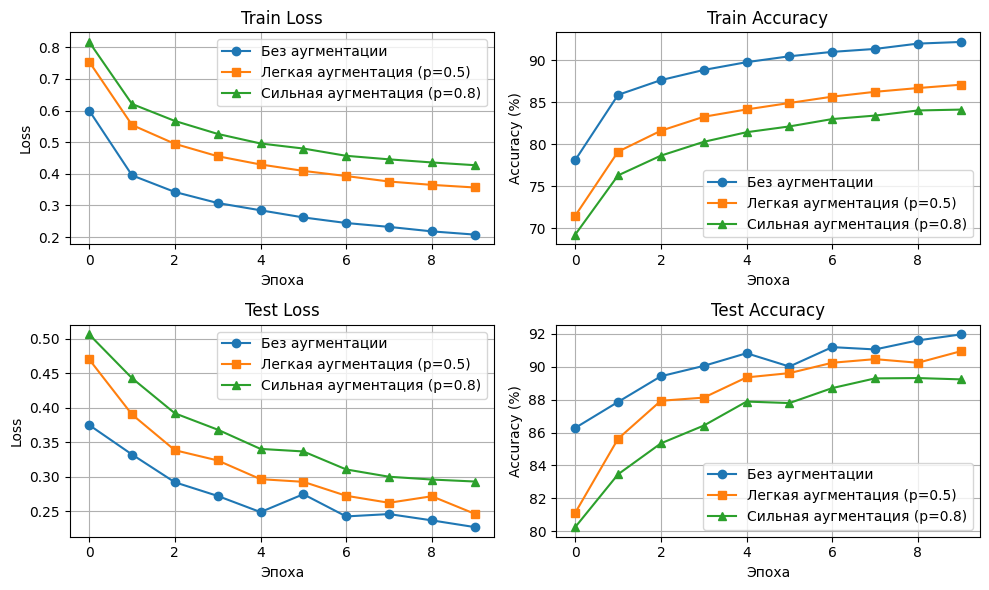

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

# График лосса на train
axes[0, 0].plot(results['no_aug']['train_losses'], label='Без аугментации', marker='o')
axes[0, 0].plot(results['aug1']['train_losses'], label='Легкая аугментация (p=0.5)', marker='s')
axes[0, 0].plot(results['aug2']['train_losses'], label='Сильная аугментация (p=0.8)', marker='^')
axes[0, 0].set_xlabel('Эпоха')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Train Loss')
axes[0, 0].legend()
axes[0, 0].grid(True)

# График accuracy на train
axes[0, 1].plot(results['no_aug']['train_accs'], label='Без аугментации', marker='o')
axes[0, 1].plot(results['aug1']['train_accs'], label='Легкая аугментация (p=0.5)', marker='s')
axes[0, 1].plot(results['aug2']['train_accs'], label='Сильная аугментация (p=0.8)', marker='^')
axes[0, 1].set_xlabel('Эпоха')
axes[0, 1].set_ylabel('Accuracy (%)')
axes[0, 1].set_title('Train Accuracy')
axes[0, 1].legend()
axes[0, 1].grid(True)

# График лосса на test
axes[1, 0].plot(results['no_aug']['test_losses'], label='Без аугментации', marker='o')
axes[1, 0].plot(results['aug1']['test_losses'], label='Легкая аугментация (p=0.5)', marker='s')
axes[1, 0].plot(results['aug2']['test_losses'], label='Сильная аугментация (p=0.8)', marker='^')
axes[1, 0].set_xlabel('Эпоха')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].set_title('Test Loss')
axes[1, 0].legend()
axes[1, 0].grid(True)

# График accuracy на test
axes[1, 1].plot(results['no_aug']['test_accs'], label='Без аугментации', marker='o')
axes[1, 1].plot(results['aug1']['test_accs'], label='Легкая аугментация (p=0.5)', marker='s')
axes[1, 1].plot(results['aug2']['test_accs'], label='Сильная аугментация (p=0.8)', marker='^')
axes[1, 1].set_xlabel('Эпоха')
axes[1, 1].set_ylabel('Accuracy (%)')
axes[1, 1].set_title('Test Accuracy')
axes[1, 1].legend()
axes[1, 1].grid(True)

plt.tight_layout()
plt.show()

Аугментации замедляют обучение, но улучшают устойчивость модели. Без аугментаций модель обучается быстрее и достигает чуть более высокой точности, однако лёгкая и сильная аугментации дают более стабильные результаты на тесте и снижают переобучение

## Задание 5. {*}  4 балла
Настройте проект в weights and biases, настройте логгинг туда из вашего цикла обучения (задание 4).
Выводите лосс и метрики на трейне и на тесте. Графики из задания 4 в таком случае можно выводить только туда.
Можете сохранять параметры обучения в качестве констант, и смотреть на сводную таблицу.

In [75]:
wandb.login(anonymous="allow")

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


True

In [76]:
wandb.init(project="fashion-mnist", name="no-aug")

In [77]:
CONFIG = {
    'batch_size': 64,
    'learning_rate': 0.001,
    'num_epochs': 10,
    'model': 'SimpleCNN',
    'optimizer': 'Adam',
    'dataset': 'FashionMNIST'
}

In [78]:
def train_model_with_wandb(model, train_loader, test_loader, num_epochs, device, run_name, aug_config):
    """Обучает модель с логированием в W&B."""
    wandb.init(
        project="spbu_dl_homework2",
        name=run_name,
        config={**CONFIG, **aug_config}
    )

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=CONFIG['learning_rate'])

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for images, labels in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}'):
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

        train_loss /= len(train_loader)
        train_acc = 100 * train_correct / train_total

        # Тестирование
        model.eval()
        test_loss = 0.0
        test_correct = 0
        test_total = 0

        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                test_total += labels.size(0)
                test_correct += (predicted == labels).sum().item()

        test_loss /= len(test_loader)
        test_acc = 100 * test_correct / test_total

        # Логирование в W&B
        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'test_loss': test_loss,
            'test_accuracy': test_acc
        })

        print(f'Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, '
              f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    wandb.finish()

In [79]:
print("=" * 50)
print("Обучение БЕЗ аугментации (с W&B)")
print("=" * 50)
model_no_aug_wb = SimpleCNN().to(DEVICE)
train_model_with_wandb(
    model_no_aug_wb,
    train_loader_no_aug,
    test_loader,
    CONFIG['num_epochs'],
    DEVICE,
    run_name='no_augmentation',
    aug_config={'augmentation': 'none'}
)

Обучение БЕЗ аугментации (с W&B)


Epoch 1/10: 100%|██████████| 938/938 [00:07<00:00, 127.06it/s]


Epoch 1: Train Loss: 0.5739, Train Acc: 79.13%, Test Loss: 0.3656, Test Acc: 86.59%


Epoch 2/10: 100%|██████████| 938/938 [00:06<00:00, 137.05it/s]


Epoch 2: Train Loss: 0.3747, Train Acc: 86.55%, Test Loss: 0.3064, Test Acc: 88.55%


Epoch 3/10: 100%|██████████| 938/938 [00:06<00:00, 134.23it/s]


Epoch 3: Train Loss: 0.3249, Train Acc: 88.16%, Test Loss: 0.2853, Test Acc: 89.28%


Epoch 4/10: 100%|██████████| 938/938 [00:07<00:00, 127.65it/s]


Epoch 4: Train Loss: 0.2918, Train Acc: 89.56%, Test Loss: 0.2850, Test Acc: 89.75%


Epoch 5/10: 100%|██████████| 938/938 [00:06<00:00, 140.52it/s]


Epoch 5: Train Loss: 0.2697, Train Acc: 90.20%, Test Loss: 0.2608, Test Acc: 90.58%


Epoch 6/10: 100%|██████████| 938/938 [00:07<00:00, 126.66it/s]


Epoch 6: Train Loss: 0.2482, Train Acc: 90.97%, Test Loss: 0.2481, Test Acc: 91.10%


Epoch 7/10: 100%|██████████| 938/938 [00:09<00:00, 97.13it/s]


Epoch 7: Train Loss: 0.2305, Train Acc: 91.57%, Test Loss: 0.2433, Test Acc: 91.16%


Epoch 8/10: 100%|██████████| 938/938 [00:07<00:00, 132.33it/s]


Epoch 8: Train Loss: 0.2176, Train Acc: 91.95%, Test Loss: 0.2561, Test Acc: 90.75%


Epoch 9/10: 100%|██████████| 938/938 [00:08<00:00, 116.09it/s]


Epoch 9: Train Loss: 0.2023, Train Acc: 92.52%, Test Loss: 0.2430, Test Acc: 91.61%


Epoch 10/10: 100%|██████████| 938/938 [00:07<00:00, 127.49it/s]


Epoch 10: Train Loss: 0.1919, Train Acc: 92.78%, Test Loss: 0.2357, Test Acc: 91.80%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▄▅▅▆▇▇▇██
test_loss,█▅▄▄▂▂▁▂▁▁
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,91.8
test_loss,0.23567
train_accuracy,92.78167
train_loss,0.1919


In [57]:
print("\n" + "=" * 50)
print("Обучение С легкой аугментацией (p=0.5) (с W&B)")
print("=" * 50)
model_aug1_wb = SimpleCNN().to(DEVICE)
train_model_with_wandb(
    model_aug1_wb,
    train_loader_aug1,
    test_loader,
    CONFIG['num_epochs'],
    DEVICE,
    run_name='light_augmentation',
    aug_config={
        'augmentation': 'light',
        'crop_prob': 0.5,
        'rotate_prob': 0.5,
        'rotate_degrees': 10
    }
)


Обучение С легкой аугментацией (p=0.5) (с W&B)


Epoch 1/10: 100%|██████████| 938/938 [00:10<00:00, 87.31it/s]


Epoch 1: Train Loss: 0.7118, Train Acc: 73.15%, Test Loss: 0.4312, Test Acc: 83.77%


Epoch 2/10: 100%|██████████| 938/938 [00:10<00:00, 91.59it/s]


Epoch 2: Train Loss: 0.5152, Train Acc: 80.79%, Test Loss: 0.3559, Test Acc: 86.90%


Epoch 3/10: 100%|██████████| 938/938 [00:10<00:00, 93.24it/s]


Epoch 3: Train Loss: 0.4593, Train Acc: 82.83%, Test Loss: 0.3269, Test Acc: 87.83%


Epoch 4/10: 100%|██████████| 938/938 [00:10<00:00, 90.16it/s]


Epoch 4: Train Loss: 0.4189, Train Acc: 84.49%, Test Loss: 0.2945, Test Acc: 89.40%


Epoch 5/10: 100%|██████████| 938/938 [00:12<00:00, 72.19it/s]


Epoch 5: Train Loss: 0.3921, Train Acc: 85.65%, Test Loss: 0.2832, Test Acc: 89.68%


Epoch 6/10: 100%|██████████| 938/938 [00:10<00:00, 89.64it/s]


Epoch 6: Train Loss: 0.3733, Train Acc: 86.36%, Test Loss: 0.2679, Test Acc: 90.05%


Epoch 7/10: 100%|██████████| 938/938 [00:14<00:00, 64.38it/s]


Epoch 7: Train Loss: 0.3606, Train Acc: 86.83%, Test Loss: 0.2562, Test Acc: 90.98%


Epoch 8/10: 100%|██████████| 938/938 [00:12<00:00, 77.92it/s]


Epoch 8: Train Loss: 0.3441, Train Acc: 87.58%, Test Loss: 0.2499, Test Acc: 91.00%


Epoch 9/10: 100%|██████████| 938/938 [00:10<00:00, 93.45it/s]


Epoch 9: Train Loss: 0.3353, Train Acc: 87.66%, Test Loss: 0.2431, Test Acc: 91.36%


Epoch 10/10: 100%|██████████| 938/938 [00:10<00:00, 89.88it/s]


Epoch 10: Train Loss: 0.3258, Train Acc: 88.02%, Test Loss: 0.2513, Test Acc: 91.08%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▄▅▆▆▇████
test_loss,█▅▄▃▂▂▁▁▁▁
train_accuracy,▁▅▆▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,91.08
test_loss,0.2513
train_accuracy,88.02
train_loss,0.32583


In [59]:
print("\n" + "=" * 50)
print("Обучение С сильной аугментацией (p=0.8) (с W&B)")
print("=" * 50)
model_aug2_wb = SimpleCNN().to(DEVICE)
train_model_with_wandb(
    model_aug2_wb,
    train_loader_aug2,
    test_loader,
    CONFIG['num_epochs'],
    DEVICE,
    run_name='strong_augmentation',
    aug_config={
        'augmentation': 'strong',
        'crop_prob': 0.8,
        'rotate_prob': 0.8,
        'rotate_degrees': 15,
        'zoom_prob': 0.5,
        'zoom_range': (0.9, 1.1)
    }
)


Обучение С сильной аугментацией (p=0.8) (с W&B)


Epoch 1/10: 100%|██████████| 938/938 [00:12<00:00, 72.35it/s]


Epoch 1: Train Loss: 0.8262, Train Acc: 68.67%, Test Loss: 0.5008, Test Acc: 80.41%


Epoch 2/10: 100%|██████████| 938/938 [00:16<00:00, 56.83it/s]


Epoch 2: Train Loss: 0.6246, Train Acc: 76.59%, Test Loss: 0.4389, Test Acc: 83.13%


Epoch 3/10: 100%|██████████| 938/938 [00:13<00:00, 70.48it/s]


Epoch 3: Train Loss: 0.5709, Train Acc: 78.28%, Test Loss: 0.3996, Test Acc: 85.51%


Epoch 4/10: 100%|██████████| 938/938 [00:13<00:00, 69.64it/s]


Epoch 4: Train Loss: 0.5356, Train Acc: 79.77%, Test Loss: 0.3703, Test Acc: 86.52%


Epoch 5/10: 100%|██████████| 938/938 [00:12<00:00, 73.37it/s]


Epoch 5: Train Loss: 0.5085, Train Acc: 80.90%, Test Loss: 0.3484, Test Acc: 87.41%


Epoch 6/10: 100%|██████████| 938/938 [00:13<00:00, 68.78it/s]


Epoch 6: Train Loss: 0.4851, Train Acc: 82.02%, Test Loss: 0.3307, Test Acc: 87.75%


Epoch 7/10: 100%|██████████| 938/938 [00:17<00:00, 53.33it/s]


Epoch 7: Train Loss: 0.4690, Train Acc: 82.59%, Test Loss: 0.3384, Test Acc: 87.23%


Epoch 8/10: 100%|██████████| 938/938 [00:12<00:00, 73.43it/s]


Epoch 8: Train Loss: 0.4516, Train Acc: 83.46%, Test Loss: 0.3037, Test Acc: 89.04%


Epoch 9/10: 100%|██████████| 938/938 [00:12<00:00, 73.04it/s]


Epoch 9: Train Loss: 0.4433, Train Acc: 83.58%, Test Loss: 0.2966, Test Acc: 89.05%


Epoch 10/10: 100%|██████████| 938/938 [00:12<00:00, 73.06it/s]


Epoch 10: Train Loss: 0.4331, Train Acc: 84.05%, Test Loss: 0.2994, Test Acc: 89.42%


epoch,▁▂▃▃▄▅▆▆▇█
test_accuracy,▁▃▅▆▆▇▆███
test_loss,█▆▅▄▃▂▂▁▁▁
train_accuracy,▁▅▅▆▇▇▇███
train_loss,█▄▃▃▂▂▂▁▁▁
epoch,10
test_accuracy,89.42
test_loss,0.29945
train_accuracy,84.04667
train_loss,0.43306
